In [5]:
from flash_attn import flash_attn_with_kvcache
import torch

bsz = 4
n_heads = 32
q_len = 5
kv_len = 100
d_model = 128

q = torch.randn(bsz, q_len, n_heads, d_model).half().cuda()
k = torch.randn(bsz, kv_len, n_heads, d_model).half().cuda()
v = torch.randn(bsz, kv_len, n_heads, d_model).half().cuda()

print(f"q: {q.shape}, k: {k.shape}, v: {v.shape}")

q: torch.Size([4, 5, 32, 128]), k: torch.Size([4, 100, 32, 128]), v: torch.Size([4, 100, 32, 128])


In [10]:
data_len = 100
seq_len = torch.full((bsz,), data_len, dtype=torch.int32).cuda()

seq_len

tensor([100, 100, 100, 100], device='cuda:0', dtype=torch.int32)

In [13]:
seq_len = torch.randint(low=10000, high=10240, size=(bsz,), dtype=torch.int32).cuda()

seq_len

tensor([10070, 10068, 10140, 10007], device='cuda:0', dtype=torch.int32)

In [23]:
cache_seqlens = torch.tensor([30, 20, 10, 100], dtype=torch.int32).cuda()
print(f"cache_seqlens: {cache_seqlens}")

import torch

range_tensor = torch.arange(1).cuda()

# Use broadcasting to add the starting index (cache_seqlens) to the range_tensor
# cache_seqlens[:, None] changes the shape to make it compatible for broadcasting
storage_ids_no_loop = cache_seqlens[:, None] + range_tensor

storage_ids_no_loop

cache_seqlens: tensor([ 30,  20,  10, 100], device='cuda:0', dtype=torch.int32)


tensor([[ 30],
        [ 20],
        [ 10],
        [100]], device='cuda:0')

In [7]:
cache_seqlens +1

tensor([ 31,  21,  11, 101], device='cuda:0', dtype=torch.int32)

In [3]:
# compute each sequence's attn_output based on the cache_seqlens

attn_output_test = flash_attn_with_kvcache(q, k_cache=k, v_cache=v, cache_seqlens=cache_seqlens, softmax_scale=1/torch.sqrt(torch.tensor(128, dtype=torch.float16)), causal=True)
attn_output_test.shape

torch.Size([4, 5, 32, 128])

In [24]:
cache_seqlens = torch.full((bsz,), kv_len, dtype=torch.int32).cuda()

In [25]:
cache_seqlens

tensor([100, 100, 100, 100], device='cuda:0', dtype=torch.int32)

In [12]:
attn_output_refs = []
bsz_idx = 0
for i in cache_seqlens:
    k_truct = k[bsz_idx:bsz_idx +1, :i, :, :]
    v_truct = v[bsz_idx:bsz_idx+1, :i, :, :]
    print(f"k_truct: {k_truct.shape}, v_truct: {v_truct.shape}")
    attn_output_ref = flash_attn_with_kvcache(q[bsz_idx:bsz_idx+1], k_cache=k_truct, v_cache=v_truct, softmax_scale=1/torch.sqrt(torch.tensor(128, dtype=torch.float16)), causal=True)
    attn_output_refs.append(attn_output_ref)
    bsz_idx += 1
    assert torch.allclose(attn_output_test[bsz_idx-1:bsz_idx], attn_output_ref, atol=1e-3), f"bsz_idx: {bsz_idx-1}, attn_output_test: {attn_output_test[bsz_idx-1:bsz_idx]}, attn_output_ref: {attn_output_ref}"


k_truct: torch.Size([1, 30, 32, 128]), v_truct: torch.Size([1, 30, 32, 128])
k_truct: torch.Size([1, 20, 32, 128]), v_truct: torch.Size([1, 20, 32, 128])
k_truct: torch.Size([1, 10, 32, 128]), v_truct: torch.Size([1, 10, 32, 128])
k_truct: torch.Size([1, 100, 32, 128]), v_truct: torch.Size([1, 100, 32, 128])


In [16]:
attn_output_refs[1]

tensor([[[[-0.2140, -0.6909,  0.8154,  ...,  0.1670,  0.1050,  0.2377],
          [-0.2330, -0.0182, -0.0674,  ...,  0.4292, -0.3501, -0.2179],
          [-0.1499, -0.4426,  0.2878,  ...,  0.6382,  0.6982,  0.1709],
          ...,
          [ 0.4016,  0.0766,  0.1216,  ...,  0.1700, -0.5640, -0.2235],
          [ 0.0381, -0.0160,  0.5967,  ..., -0.0669,  0.2133,  0.0343],
          [-0.2751,  0.0526, -0.2031,  ..., -0.0446,  0.0818,  0.4768]],

         [[ 0.2859, -0.4028, -0.5942,  ...,  0.5195, -1.3359, -0.7524],
          [-0.1333, -0.0883, -0.0278,  ...,  0.0974, -0.2502, -0.1698],
          [-0.1354, -0.2040, -0.0078,  ..., -0.1407,  0.0199,  0.0045],
          ...,
          [ 0.7915,  0.1787, -0.0656,  ...,  0.3474, -0.4114,  0.0555],
          [-0.4763, -0.0390, -0.0581,  ..., -0.2144,  0.3833,  0.0718],
          [-0.0518,  0.3843, -0.5093,  ..., -0.0288, -0.3535,  0.6528]],

         [[ 0.1794, -0.5269,  0.6548,  ...,  0.3735, -0.1522,  0.2505],
          [-0.0624, -0.4580,  

In [17]:
attn_output_test[1]

tensor([[[-0.2140, -0.6909,  0.8154,  ...,  0.1670,  0.1050,  0.2377],
         [-0.2330, -0.0182, -0.0674,  ...,  0.4292, -0.3501, -0.2179],
         [-0.1499, -0.4426,  0.2878,  ...,  0.6382,  0.6982,  0.1709],
         ...,
         [ 0.4016,  0.0766,  0.1216,  ...,  0.1700, -0.5640, -0.2235],
         [ 0.0381, -0.0160,  0.5967,  ..., -0.0669,  0.2133,  0.0343],
         [-0.2751,  0.0526, -0.2031,  ..., -0.0446,  0.0818,  0.4768]],

        [[ 0.2859, -0.4028, -0.5942,  ...,  0.5195, -1.3359, -0.7524],
         [-0.1333, -0.0883, -0.0278,  ...,  0.0974, -0.2502, -0.1698],
         [-0.1354, -0.2040, -0.0078,  ..., -0.1407,  0.0199,  0.0045],
         ...,
         [ 0.7915,  0.1787, -0.0656,  ...,  0.3474, -0.4114,  0.0555],
         [-0.4763, -0.0390, -0.0581,  ..., -0.2144,  0.3833,  0.0718],
         [-0.0518,  0.3843, -0.5093,  ..., -0.0288, -0.3535,  0.6528]],

        [[ 0.1794, -0.5269,  0.6548,  ...,  0.3735, -0.1522,  0.2505],
         [-0.0624, -0.4580,  0.0086,  ..., -0

In [9]:
import torch

# 定义两个tensor和index
tensor1 = torch.zeros(2, 100, 32, 128).cuda()  # 目标tensor
tensor2 = torch.randn(2, 5, 32, 128).cuda()    # 源tensor
indices = torch.tensor([[9, 10, 11, 12, 13], [29, 30, 31, 32, 33]]).cuda()

# 将indices调整形状以适配scatter的输入要求
# 我们需要一个与tensor1在除了第二维之外的其他维度匹配的indices形状
indices_expanded = indices.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 32, 128)

# 使用scatter_并行复制tensor2到tensor1的指定位置
# 这将直接修改tensor1的内容
tensor1.scatter_(1, indices_expanded, tensor2)

# 验证操作，例如检查tensor1的某些索引位置是否已更新
# 注意：实际运行中可能不需要这些验证步骤，它们只是为了演示操作成功
print(tensor1.shape)  # 应为 torch.Size([2, 100, 32, 128])
print(tensor1[:, 9, :, :].shape)  # 检查一个被更新的索引位置，应为 torch.Size([2, 32, 128])
print(tensor1[:, 29, :, :].shape)  # 检查另一个被更新的索引位置，同样应为 torch.Size([2, 32, 128])


torch.Size([2, 100, 32, 128])
torch.Size([2, 32, 128])
torch.Size([2, 32, 128])


In [16]:
tensor1[0, 9:13].shape

torch.Size([4, 32, 128])

In [19]:
a = torch.tensor([1,2,3,4])
a[1:2]

tensor([2])

In [14]:
a = ['the\nmother of flowers, and her children are the children of the year; but\nher own are the first-born, the violet, the anemone, the May-flower.\nThe early Greeks called her the month of the Hyacinth, the flower of\nlove; and the month of the Daphne, the flower of friendship. She is the\nmother of all the flowers of the spring, and she is herself the first\nflower of the spring.\n\n\nTHE AUTHOR\'S PREFACE.\n\n\nThe following pages are not, as I have been informed, the first\nattempt to give a connected history of the _Origin of Species_.\n\nIn the year 1842, I published a small work entitled "Vestiges of the\nNatural History of Creation," which, in the following year, was\ntranslated into German and into French, and has been several times\nreprinted in this country. It was not, however, until 1859, that the\npresent volume appeared. In that year, Mr. Wallace, who was then a\nnaturalist in the East Indies, sent to', "it\ncould not be settled by any argument; for men of equal sincerity and\nintelligence on both sides were in deadly conflict. It is only in the\nlong run of time that moral convictions are established; and even then\nthey are established, not by arguments, but by the slow action of\nprejudice, of custom, and of the natural moral instincts of men.\n\n[Footnote 1: The slavery question was of course much more complicated\nthan this sketch would indicate. See, for example, the discussion of it\nin Professor Beard's _Rise of American Civilization_, Vol. II, pp.\n453-484.]\n\nA large part of our practical life is governed by the question of what\nis best for the practical interests of ourselves and others. This is the\npoint of view from which we look at questions of economics and\npolitics, and at questions of the distribution of wealth and power. The\nquestion of whether the United States should have a protective tariff,\nor whether we should adopt the free-trade policy of England, is one of\nthis sort. In such cases we do not ask, What is", 'won; and the poet, who had been in\nFrance with Edward II in 1360, would have had many opportunities\nof studying the character of the French people, and of\nacquiring the knowledge of their language which he afterwards\ndisplayed. In 1367, he was in Flanders, where he saw the\nsplendid pageants of the Flemish nobles, and the gayeties of\ntheir Court; and in 1369, he was in Spain, where he saw the\nCourt of the king of Castile. He returned to England in 1370,\nand in 1372 was again in France, where he was taken prisoner\nat the battle of Poitiers. The poet was treated with great\nkindness by the French King, who had him sent to Paris, and\nallowed him to reside there for some time. He was, however,\nafterwards taken to England, and was in 1374, when he was\nthirty-six years old, appointed Comptroller of the Customs\nand Subsidies in the Port of London, an office which gave him\nconsiderable authority', 'breaks of the old feudal spirit, and\nthe Corsican people were not yet thoroughly weaned from the\nblood-revenge. But the strong hand of the energetic chief soon put\ndown these disorders, and his administration was generally\nsatisfactory. In 1764 he was elected president of the Great Council,\nwhich was the equivalent of a ministry, and he was soon after made\nvice-king. The Genoese had now been driven from the island, and the\nCorsicans had become the owners of the island. But the French king,\nLouis XV, who had long been the patron of the island, and had\nsupported the Corsican patriots in their struggles, was now\ndisappointed and exasperated by their rejection of his choice of\nviceroy. He had made them a free state, and he now insisted that they\nshould recognize his nominee. The Corsicans were still unconquered,\nand their pride and nationalism were in the ascendant. They refused,\nand the French court was not yet prepared to make war on a people who\nhad never been conquered and', '," said the Prussian. "You are a lieutenant-colonel, and I am a\ncolonel," said the other. "You are a lieutenant-colonel, and I am a\ncolonel," said the Prussian, "and you are my prisoner." "No, no," said\nthe Russian, "I am not your prisoner, I am your prisoner." "You are my\nprisoner," said the Prussian. "No, no," said the Russian, "you are my\nprisoner." "You are my prisoner," said the Prussian. "No, no," said the\nRussian, "you are my prisoner." "You are my prisoner," said the Prussian.\n"No, no," said the Russian, "you are my prisoner." "You are my\nprisoner," said the Prussian. "No, no," said the Russian, "you are my\nprisoner." "You are my prisoner," said the Prussian. "No, no," said the\nRussian, "you are my prisoner." "You are my prisoner," said the Prussian.\n"No, no," said the Russian, "you', '\na truth in the old adage that "the dead are not dead."\n\nIf we could only trace back the life of man to its beginning, and\nfollow it on its way to the present, we should see that the\ndevelopment of the human race has been through two main lines of\nevolution: one is the line of the male, and the other that of the\nfemale. The male has developed in a definite direction, and has\nattained to a higher degree of perfection, in the course of its\nevolution. It is the more perfect life, and the more perfect life is\nthe more perfect individual. The male has in a measure overcome the\nrestraints of its environment. It has won for itself a wider\nliberation than the female. But in the past woman has been the\nsufferer. She has been held down by the male, and has been in a sense\nthe less perfect life. It is not, therefore, surprising that in\nconsidering the sex-relationship, we should find that woman has been\nthe more completely modified by the environment.\n\nTo understand the present sex-relationship, we must consider the\nbiological anteced', 'were reprinted in the _Catholic\nQuarterly_ in 1862, and are interesting as the earliest specimens of his\nhistorical style.  The _Home and Foreign Review_ was edited by the\nRev. Dr. Pusey, and the articles in it were anonymous.  In 1863 Sir John\nActon published his _Lectures on Modern History_, in which he explained\nhis views of the relation of the Church to the State.  The book was\nreviewed in the _Edinburgh_ by Mr. Froude, and in the _Quarterly_ by Mr.\nGladstone.  It was a controversial work, and in it Acton, as Mr.\nGladstone said, took his stand upon the principle that a Liberal\nGovernment ought to be the Government of the people, and that the\nChurches were the organs of the people.  This, as Mr. Gladstone\nexplained, was an hypothesis which could be maintained only by\ndistorting the meaning of words, and by a series of arbitrary\nassumptions.  Mr. Gladstone did not dispute the proposition that the', 'it may be compared with the rites of the Thesmophoria, which were held in\nOctober, and which we shall presently describe.\n\n(M10) In the myth of Dionysus, as in that of Adonis, the god is represented\nas a youthful husbandman, a vine-dresser, who, while reaping his harvest,\nis treacherously slain by the Titans. In the case of Dionysus, however,\nthe myth is more consistent with the nature of the god, for he is\nespecially the god of the vine and of the grape-harvest. Thus in the\nDionysiac festival at Athens the _Thyestes_ was represented as a vintage\nscene. It was the custom to set up a vine-stock in the theatre, which was\ndecorated with grapes and ivy, and to crown the vine with a wreath of\nivy.(67) The vine was the most conspicuous symbol of Dionysus, and in the\nhands of the god it was the chief implement of his work. As a v', 'say, \'Welcome.\'"\n\nMr. Mole was led to the door and Matilda slipped her hand into his and\nthey passed out into the night.\n\n\n\nII\n\nMARRIAGE\n\nThe night was hot and still, and the stars were bright and clear.\n\n"Come along," said Matilda.\n\n"But where?"\n\n"My aunt\'s."\n\n"Your aunt\'s!"\n\n"Yes, my aunt\'s."\n\n"But--but I can\'t go to your aunt\'s."\n\n"Why not?"\n\n"I--I don\'t know her."\n\n"But you\'re my friend."\n\n"I\'m not your friend."\n\n"You are, though."\n\n"I\'m not."\n\n"You are."\n\n"I\'m not."\n\n"You are, though."\n\n"I\'m not."\n\n"You are, though."\n\n"I\'m not."\n\n"You are, though."\n\n"I\'m not."\n\n"You are, though."\n\n"I\'', 'are they that _follow me_." He replied, "these are they\nthat _follow me_ in all things." I asked, "are all things\n_necessary_ to salvation?" He replied, "No; but all things\n_necessary_ to _follow me_." I asked, "What are the necessary\nthings?" He replied, "To _follow_ me, is to keep all the\ncommandments of God." I asked, "what are the commandments of God?"\nHe replied, "Thou shalt have no other Gods before me; thou shalt\nnot take the name of the Lord thy God in vain; thou shalt not\nkill, nor commit adultery, nor steal, nor bear false witness, nor\ncovet thy neighbor\'s goods." I asked, "are these all the\ncommandments of God?" He replied, "Yes." I asked, "are they all\nnecessary to salvation?" He replied, "Yes." I asked, "then how can\na man keep all these commandments, and still commit murder, or\nadultery, or steal, or bear false witness, or covet his\nneighbor', '-three he had already reached the height of his ambition,\nand was beginning to feel that he had a right to look forward to the\nfuture with some confidence. "I am well placed," he writes in the\nJournal, "and I have every reason to hope that my future will be a\nsuccessful one."\n\nThe years which followed were not, however, years of success. On the\ncontrary, the very success which he had won, by a steady and unwearying\neffort, began to produce in him the effect which M. Renan describes as\nthat of "the prick of the thorn." "He was a professor," he says, "and\nthe professorial chair was not the only one he occupied. He had also\nthe chair of moral philosophy, and that of history, and he was a\nmember of the Geneva Academy. He had, in fact, become a man of\nbusiness. He was a man of business, and he had a taste for business,\nand, above all, he was a man of business who was a philosopher and\na poet. This was a combination which was not likely to satisfy him.\nPhilosophy', 'a thousand flowers.\n\nThe garden of the Hesperides was a celebrated spot, and the golden apples\nthere, were the subject of many a mythological tale. The gardens of\nAlcinous, and of the Queen of the Amazons, were renowned for their\nsplendour, and for the rare plants which they produced.\n\nBut it is not our province to pursue the subject of gardens in ancient\ntimes. We shall, however, in the course of our peregrinations, be led to\nthe gardens of Greece, and to those of the Romans, as we proceed in our\nresearches.\n\nWe have no idea of the antiquity of gardens in this country. The\nmonasteries, however, were, in former times, the patrons of them.\n\nGerarde, in his Herbal, mentions the gardens of the Abbey of St. Albans,\nand of the Abbey of Westminster; and he says, that "the gardens of the\nAbbey of Westminster, were the most famous in England, and that they\ncontained the rarest fruits, herbs, and flowers']

In [30]:
a = ['the\nmonth of the _Aphrodite_ or Venus, and of the _Anna Perenna_, or\nperennial spring. The _Anna Perenna_ was a Roman festival, in honor of\nthe goddess of perpetual youth, and was celebrated on the first of April\nby the sacrifice of a cock and a dog. The dog was to be tied to a tree,\nand the cock to a stake, and the victims were to be slain with a knife\nand a stone, to indicate that the power of the goddess was not to be\nsuspected of being derived from the blood of a beast. A feast was then\nheld in honor of the goddess, and a sacrifice of eggs was offered to\nher, which were distributed among the guests. This festival was probably\nconnected with the _Lupercalia_, which was celebrated on the fifteenth\nof February, and was attended by the sacrifice of a goat and a dog. It\nis related that the founder of Rome, Romulus, was born on the fifteenth\nof February, and that, when the she-wolf found him, he was sucking a', 'it was\nnot until the war, and that not until the terrible death roll of the\nwar, made the moral wrongness of slavery so clear that it could not be\ndenied. The same is true of the question of woman suffrage, and of\nalmost all of the great movements of reform, which have had to wait until\nthe moral convictions of the country had become strong enough to make\nthem irresistible.\n\nThere are certain other questions, however, in which the moral right and\nwrong is so clear that it is only a question of how far the right should\nbe carried. The question of the death penalty, for example, is not\nwhether it is right to kill men for killing other men, but whether it is\nright to kill men for killing other men, and whether it is right to\npunish the murderer by killing him. The question of the death penalty\nhas been much debated in recent years, and the arguments on both sides\nhave been of a high order.\n\n[1] See, for example, the "Essay on Slavery," by Benjamin Rush, in the\n_Pennsylvania Packet_, May', 'won, and the French were driven to sue\nfor peace; but the English king, not satisfied with the\nconcessions of his enemy, marched to Calais, and laid siege to\nthat fortress, which he took in 1359.  Chaucer, in the\n"Court of Love," has made his knight say that he was "at the\ntaking of Calais;" and the "Troilus and Cressida" of 1386 is\nwritten in the strain of a man who had been there and seen it.\nIt is not certain whether Chaucer accompanied the King in the\nsecond expedition of 1360, but he was certainly present in the\nthird and last expedition, in 1369, when the English army\nreturned home in triumph, and Edward was received with\nenthusiastic acclamation at London.  On this occasion, Chaucer\nwas a witness to the coronation of the queen, and was appointed\none of the King\'s esquires.  His military career had not been\nof long duration, but it had been sufficiently honourable to\ngive him a', 'breaks in the towns, and he was\ncompelled to repress them with a firm hand. In 1764 a party of\nrevolutionists, among them his own brother, were arrested and\ncondemned to death, and Paoli, in spite of his own horror of capital\npunishment, was forced to sign the order for their execution. He was\nalso obliged to resist the exorbitant demands of the Genoese for\nreparation of damages, and to refuse the aid of the Pope and of\nFrance. But the latter was now in the hands of the austere and\nconservative Choiseul, who had no sympathy with the Corsicans, and\nwould not have assisted them even if he had had the power. Paoli,\nhowever, was in close correspondence with the French court and with\nthe most liberal minds in France and England, and he was not without\nhope that he might yet be able to secure the assistance of the former.\n\nThe Corsican general was now in his fortieth year. He had been a\nstudent at the university of Padua, and had served with distinction\nin the Neap', '." "You are only a colonel of the _household_." "I have as much\nright to be a colonel of the household as you have to be a colonel of\nthe _household_." The dispute was carried to the king, who was at\nsupper, and who, not being able to settle it, sent for the grand-duke,\nwho was sitting in the next room. "Well, my lord," said the king, "here\nis a dispute between the two colonels, which I cannot settle. Will you\nbe so good as to decide it?" "Certainly, sire," said the grand-duke,\n"and I shall be very happy to be able to give satisfaction to both."\n"Well, gentlemen," said the king, "you have both your swords, and may\nsettle the matter with them." The dispute was at once settled by the\nPrussian, who had the misfortune to be killed on the spot.\n\nA curious anecdote is given of the Prussian minister, the Baron de\nGoltz, a man of singular character, and one of the most skilful\ndiplom', 'lies the great hope for the future of the race.\n\nBut this is not all. It is important to note that in the higher forms\nof life, and especially in the human race, the conditions of\nenvironment are so complex and so important that they can be\nconsidered as another and a very powerful factor in the shaping of the\nindividual. The individual is not only a mosaic of hereditary\ncontributions, but it is also a mosaic of external influences, or\nNurture stimuli. It is these that make the difference between the\nindividual and the race. The individual is a unit of the race, and\nwhile the race is a unity the individual is a unit of the race. The\nrace is the heredity of the past, the individual is the heredity of\nthe present, and the individual and the race are linked together by\nthe Nurture stimuli. This is the reason why the race is of such\nimportance. It is the race that is the real, and not the individual\nunit. It is the race that is the centre of evolution, and not the\nindividual.\n\nNow it is possible to trace the', 'review, and some others, were reprinted in\n1862, with a preface, under the title of _Liberty and Equality_.  In\n1863 he published a _History of Liberty_, in two volumes, in which he\ntraced the origin of the idea of liberty from the conception of the\nhuman personality.  In 1864 he wrote a series of articles on the _History\nof Freedom_, which were afterwards reprinted in the same volume with\n_Liberty and Equality_.  The last of these articles was on the\n_Economic Conditions of Liberty_, and it was the first of a series of\narticles on the _Economic Conditions of Reform_ which appeared in the\n_Edinburgh Review_ for April 1865.  In 1866 appeared _Lectures on Modern\nHistory_, and in 1867 _Lectures on Modern History_, second series.  These\nwere the only books which he published in his lifetime.  In 1870 he\ncontributed a series of articles to the _Edinburgh Review_ on the\n_', 'it is known that at Argos there was a Dionysia festival in the spring and\nanother in the autumn.(67) At Thebes, in the spring, the festival of\nDionysus was celebrated by the women alone. They tore in pieces a bull\nsacrificed to the god, and then, with their blood-stained hands, they\npainted their faces and limbs in imitation of the marks of wounds on the\nbody of Dionysus. Then they danced and sang in the streets, shouting and\nlaughing, and shaking their heads and their breasts with a motion which\nthe Greeks compared to the rattling of the winnowing-fan.(68)\n\n(M10) The story of the death and resurrection of Dionysus is thus\nnaturally associated with the annual cycle of vegetation. In the spring\nthe god is born; in the autumn he dies and is buried; in the spring he is\nresurrected and renews the life of the world. The Dionysiac rites\ntherefore had the double function of aiding the revival', 'the kindness you have shown her, we are grateful. We are a\nfamily--a theater family--and we stick together. I\'m not particular\nnoble in my sentiments, but plain and straightforward. I\'m an English\nman, and I say: \'My country right or wrong.\' I\'m a family man, and I\nsay: \'My niece is my niece, right or wrong.\' Them\'s my sentiments,\nand I drink toward you."\n\nAnd again the clatter of tongues.\n\n"I\'m not particular noble in my sentiments, but plain and straightforward.\nI\'m an Englishman, and I say: \'My country right or wrong.\' I\'m a family\nman, and I say: \'My niece is my niece, right or wrong.\' Them\'s my\nsentiments, and I drink toward you."\n\nHe drank, and they all drank, and the clatter of tongues began again.\n\n"I\'m not particular noble in my sentiments, but plain and straightforward.\nI\'m an Englishman, and I say: \'My country right or wrong.\' I\'', '_words_ shall not pass away till all is fulfilled?" He\nreplied, "I do not know, but it is a mystery." I then asked him\nwhat was the meaning of the following words of Jesus: "He that\nbelieveth and is baptized shall be saved; but he that believeth not\nshall be damned." He replied, "I do not know, but it is a mystery."\n\nI then inquired what was the meaning of the following words of\nJesus: "These signs shall follow them that believe: In my name\nthey shall cast out devils; they shall speak with new tongues; they\nshall take up serpents; and if they drink any deadly thing, it\nshall not hurt them; they shall lay hands on the sick, and they\nshall recover."\n\nHe replied, "I do not know, but it is a mystery."\n\nI then inquired what was the meaning of the following words of\nJesus: "He that believeth and is baptized shall be saved; but he\nthat believeth not shall be damned. And these signs shall follow\nthem that believe:']

In [31]:
a[2]

'won, and the French were driven to sue\nfor peace; but the English king, not satisfied with the\nconcessions of his enemy, marched to Calais, and laid siege to\nthat fortress, which he took in 1359.  Chaucer, in the\n"Court of Love," has made his knight say that he was "at the\ntaking of Calais;" and the "Troilus and Cressida" of 1386 is\nwritten in the strain of a man who had been there and seen it.\nIt is not certain whether Chaucer accompanied the King in the\nsecond expedition of 1360, but he was certainly present in the\nthird and last expedition, in 1369, when the English army\nreturned home in triumph, and Edward was received with\nenthusiastic acclamation at London.  On this occasion, Chaucer\nwas a witness to the coronation of the queen, and was appointed\none of the King\'s esquires.  His military career had not been\nof long duration, but it had been sufficiently honourable to\ngive him a'

In [17]:
tensor2[0].shape

torch.Size([5, 32, 128])

In [18]:
torch.allclose(tensor1[0, 9:14], tensor2[0], atol=1e-3)
torch.allclose(tensor1[1, 29:34], tensor2[1], atol=1e-3)

True

In [24]:
a = torch.tensor([[  278,  1552,  3647,  1474,   382, 29899,  3250],
        [  263,    13, 11102,   406,  1784,  1781,  1757],
        [ 2113,   491,   322,   678,  9821,  1629,   278],
        [ 8690, 29879,   310,   607,   892,  9508,   287],
        [ 1213,   376,  8241, 29891, 29892,   541,   306],
        [   13, 29874,  4868,   310,   278,  6114,   393],
        [ 9076, 29892,   278,   491, 29871,  1494, 29934],
        [  277,   338,   505,  1063,   577,   310,   278],
        [29892,  8889, 29892,   674,   263, 16615, 29892],
        [  528,  1997,  5360, 13874, 12307,   408,   266]], device='cuda:0')

In [25]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("JackFram/llama-68m")
tokenizer.batch_decode(a, skip_special_tokens=True)

['thethefectually E-day',
 'a\nwasere many good men',
 'won by and Ch poet year the',
 'breaks of which were prompted',
 '." "Yesy, but I',
 '\na constant of the woman that',
 'review, the by  followingR',
 'it is have been so of the',
 ', sir, will a gentleman,',
 'shalt love thy neighbor as th']

In [29]:
if a.min()>10:
    print(1)

1


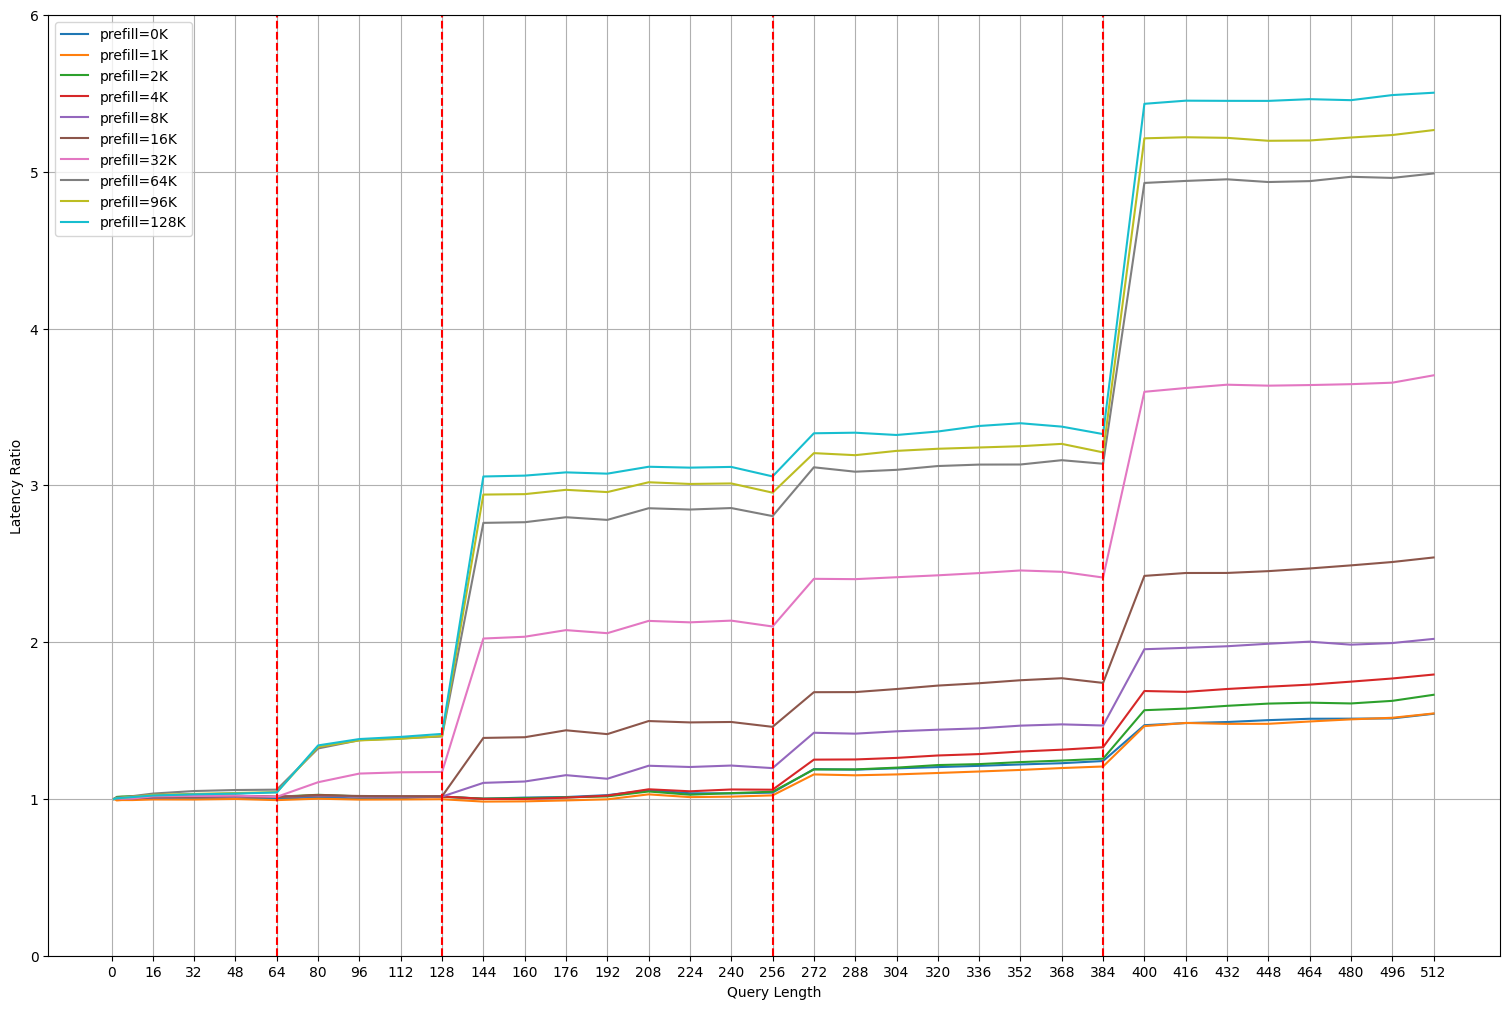

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_turning_point(file_path):
    df = pd.read_csv(file_path)
    df = df.sort_values(by=['prefill','len'])

    prefill_list = df['prefill'].unique().tolist()
    len_list = df['len'].unique().tolist()

    y = [df[df['prefill'] == prefill]['latency'].tolist() for prefill in prefill_list]

    plt.figure(figsize=(15,10))
    plt.grid()

    k=0
    for i in y:
        plt.plot(len_list,[m / i[0] for m in i], label=f'prefill={str(int(prefill_list[k]/1000))}K')
        k+=1

    plt.ylim(0,6)
    # draw a vertical line at x = 128
    plt.axvline(x=64, color='r', linestyle='--')
    plt.axvline(x=128, color='r', linestyle='--')
    plt.axvline(x=256, color='r', linestyle='--')
    plt.axvline(x=384, color='r', linestyle='--')
    plt.legend()
    plt.tight_layout()
    # xticks: step size 16
    plt.xticks(np.arange(0, 512+16, 16))
    plt.xlabel('Query Length')
    plt.ylabel('Latency Ratio')

file_path = '/var/cr06_data/beidic/LongContextInfer/benchmark/report/Turning_point.csv'
plot_turning_point(file_path)

In [2]:
import figures
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

plt.rcParams["font.family"] = "Times New Roman"
sns.set_theme()
# color1='#8da0cb'
# color2='#fc8d62'
# color3='#66c2a5'
# color4='brown'

color1 = '#66c2a5'
color2 = '#fc8d62'
color3 = '#8da0cb'
color4 = '#e78ac3'
color5 = '#a6d854'

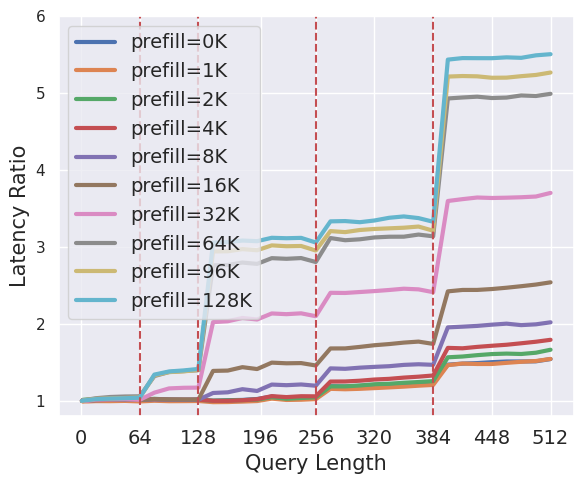

In [23]:
def plot_turning_point(file_path):
    df = pd.read_csv(file_path)
    df = df.sort_values(by=['prefill','len'])

    prefill_list = df['prefill'].unique().tolist()
    len_list = df['len'].unique().tolist()

    y = [df[df['prefill'] == prefill]['latency'].tolist() for prefill in prefill_list]

    plt.figure(figsize=(6,5))
    plt.grid()

    k=0
    for i in y:
        plt.plot(len_list,[m / i[0] for m in i], label=f'prefill={str(int(prefill_list[k]/1000))}K', linewidth=3)
        k+=1

    plt.ylim(0.8,6)
    # draw a vertical line at x = 128
    plt.axvline(x=64, color='r', linestyle='--')
    plt.axvline(x=128, color='r', linestyle='--')
    plt.axvline(x=256, color='r', linestyle='--')
    plt.axvline(x=384, color='r', linestyle='--')
    plt.legend(fontsize=14, loc='upper left')
    plt.grid()
    # xticks: step size 16
    plt.xticks(np.arange(0, 512+16, 32))
    plt.xlabel('Query Length', fontsize=15)
    plt.ylabel('Latency Ratio', fontsize=15)
    plt.xticks(fontsize=14)
    # plt.title('Latency Ratio vs. Query Length for Different Prefill Length (Llama-7B-128K, bsz=1)', fontsize=15)
    # adjust dpi
    plt.tight_layout()
    plt.xticks([0,64, 128, 196, 256, 320, 384,448, 512])
    plt.savefig('Turning_point.png', dpi=300)

file_path = '../benchmark/report/Turning_point.csv'
plot_turning_point(file_path)

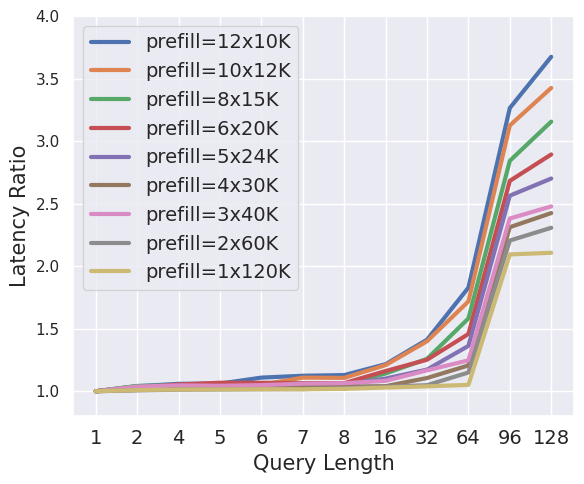

In [26]:
def plot_turning_point(file_path):
    df = pd.read_csv(file_path)
    df = df.sort_values(by=['prefill','len'])

    prefill_list = sorted(df['prefill'].unique().tolist())
    prefill_list = prefill_list[1:]
    len_list = sorted(df['len'].unique().tolist())

    y = [df[df['prefill'] == prefill]['latency'].tolist() for prefill in prefill_list]

    plt.figure(figsize=(6,5))
    plt.grid()

    k=0
    for i in y:
        plt.plot([str(x) for x in len_list],[m / i[0] for m in i], label=f'prefill={int(120*1024/prefill_list[k])}x{str(int(prefill_list[k]/1024))}K', linewidth=3)
        k+=1

    plt.ylim(0.8,4)
    # draw a vertical line at x = 128
    # plt.axvline(x=64, color='r', linestyle='--')
    # plt.axvline(x=128, color='r', linestyle='--')
    plt.legend(fontsize=14, loc='upper left')
    plt.grid()
    # xticks: step size 16
    # plt.xticks(np.arange(0, 128+16, 16))
    plt.xlabel('Query Length', fontsize=15)
    plt.ylabel('Latency Ratio', fontsize=15)
    plt.xticks(fontsize=14)
    # plt.title('Latency Ratio vs. Query Length for Different Batch (Llama-7B-128K, sum=120K)', fontsize=15)
    # adjust dpi
    plt.tight_layout()
    plt.savefig('Turning_point_bsz.png', dpi=300)

file_path = '../benchmark/report/Turning_point_2.csv'
plot_turning_point(file_path)

In [101]:
y_list

[0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0]

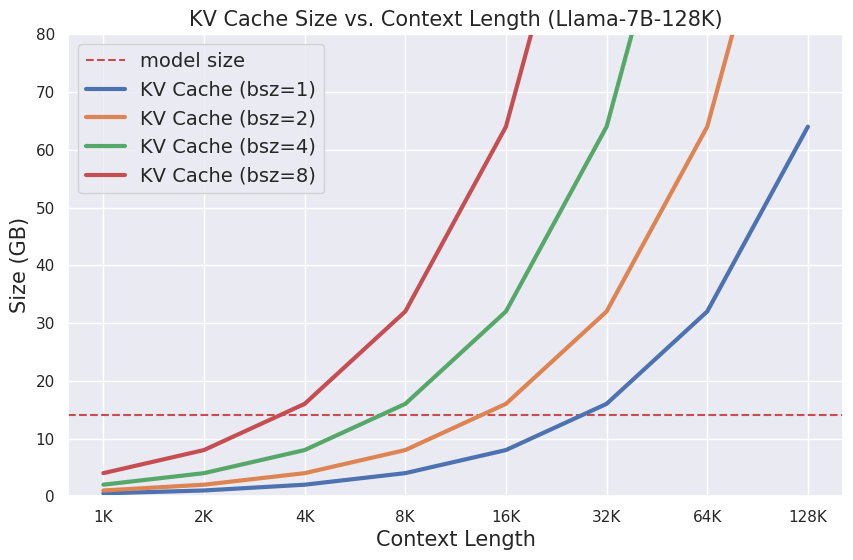

In [112]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.axhline(y=14, color='r', linestyle='--', label="model size")
x_list = [1, 2, 4, 8, 16, 32, 64, 128]
y_list = [x/2 for x in x_list]
plt.plot([str(x)+'K' for x in x_list], y_list, label='KV Cache (bsz=1)', linewidth=3)
y_list = [x for x in x_list]
plt.plot([str(x)+'K' for x in x_list], y_list, label='KV Cache (bsz=2)', linewidth=3)
y_list = [x*2 for x in x_list]
plt.plot([str(x)+'K' for x in x_list], y_list, label='KV Cache (bsz=4)', linewidth=3)
y_list = [x*4 for x in x_list]
plt.plot([str(x)+'K' for x in x_list], y_list, label='KV Cache (bsz=8)', linewidth=3)
plt.ylim(0, 80)
plt.legend(fontsize=14, loc='upper left')
plt.xlabel('Context Length', fontsize=15)
plt.ylabel('Size (GB)', fontsize=15)
plt.title('KV Cache Size vs. Context Length (Llama-7B-128K)', fontsize=15)
plt.savefig('KV_Cache_Size.png', dpi=300)

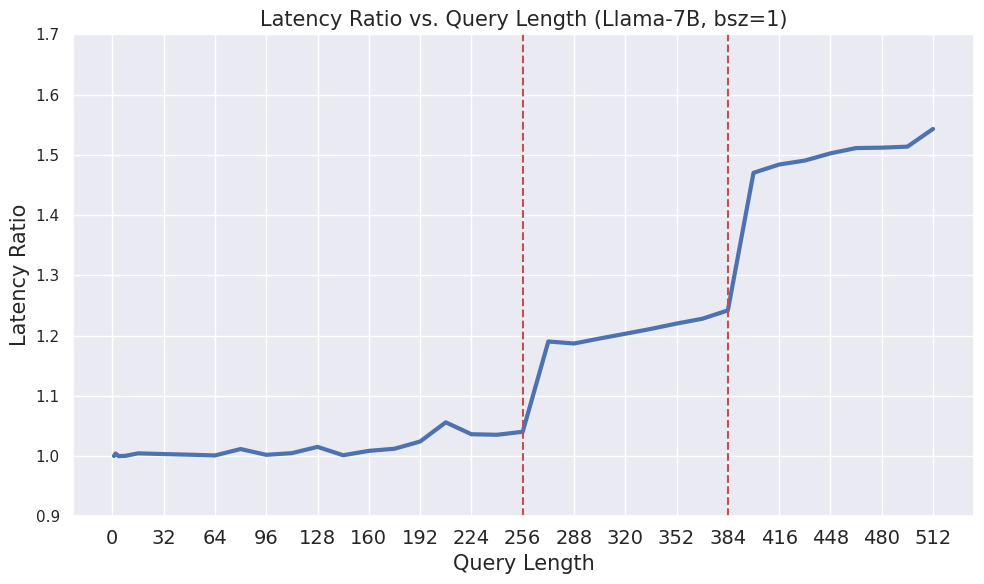

In [53]:
def plot_turning_point(file_path):
    df = pd.read_csv(file_path)
    df = df.sort_values(by=['prefill','len'])

    prefill_list = df['prefill'].unique().tolist()
    prefill_list = prefill_list[:1]
    len_list = df['len'].unique().tolist()

    y = [df[df['prefill'] == prefill]['latency'].tolist() for prefill in prefill_list]

    plt.figure(figsize=(10,6))
    plt.grid()

    k=0
    for i in y:
        plt.plot(len_list,[m / i[0] for m in i],linewidth=3)
        k+=1

    plt.ylim(0.9,1.7)
    # draw a vertical line at x = 128
    plt.axvline(x=256, color='r', linestyle='--')
    plt.axvline(x=384, color='r', linestyle='--')
    plt.grid()
    # xticks: step size 16
    plt.xticks(np.arange(0, 512+16, 32))
    plt.xlabel('Query Length', fontsize=15)
    plt.ylabel('Latency Ratio', fontsize=15)
    plt.xticks(fontsize=14)
    plt.title('Latency Ratio vs. Query Length (Llama-7B, bsz=1)', fontsize=15)
    # adjust dpi
    plt.tight_layout()
    plt.savefig('Turning_point.png', dpi=300)

file_path = '/var/cr06_data/beidic/LongContextInfer/benchmark/report/Turning_point.csv'
plot_turning_point(file_path)

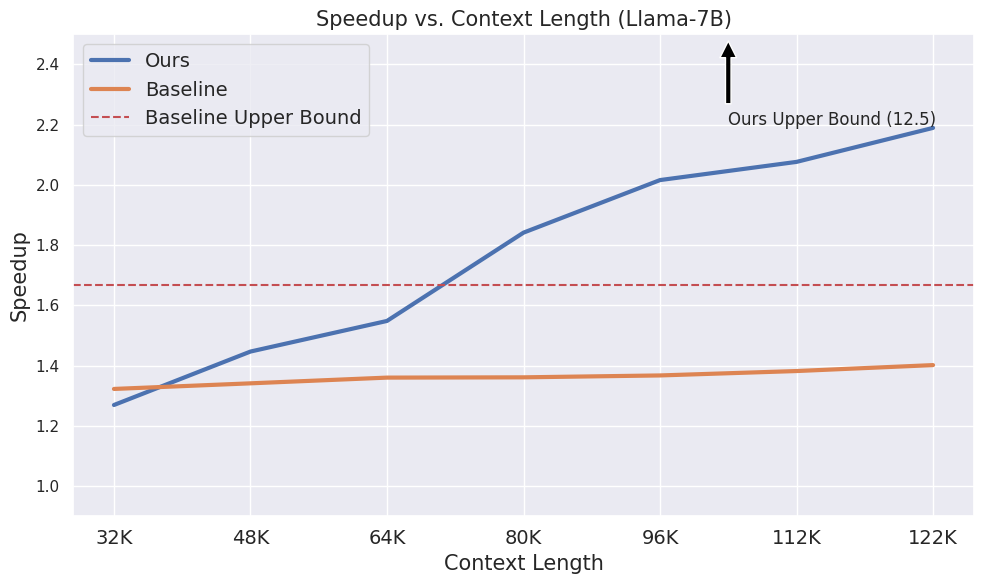

In [56]:
x_list = ['32K', '48K', '64K', '80K', '96K', '112K', '122K']
y_list = [1.26935707, 1.44679962, 1.54844512, 1.84158973, 2.01610863, 2.07650389, 2.18939503]
y_list_68m = [1.3226696211272208, 1.341290,1.3602825831719085, 1.3612097,1.3674932344219783,1.382094, 1.4018341199661668]
plt.figure(figsize=(10,6))
plt.grid()


plt.plot(x_list,y_list,linewidth=3, label='Ours')
plt.plot(x_list,y_list_68m,linewidth=3, label='Baseline')
plt.axhline(y=1.6666666667, color='r', linestyle='--', label="Baseline Upper Bound")
plt.ylim(0.9,2.5)
plt.grid()
# xticks: step size 16
# plt.xticks(np.arange(0, 512+16, 32))
plt.xlabel('Context Length', fontsize=15)
plt.ylabel('Speedup', fontsize=15)
plt.legend(fontsize=14, loc='upper left')
plt.xticks(fontsize=14)
plt.title('Speedup vs. Context Length (Llama-7B)', fontsize=15)
plt.annotate('Ours Upper Bound (12.5)', xy=(4.5, 2.49), xytext=(4.5, 2.2), arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
plt.tight_layout()

In [141]:
a = [12.219286734617597, 8.895715571002562, 9.393348111894731, 11.637066904680069, 10.345891311024074, 10.937329383950283, 10.132136548765454, 10.39833029662685, 10.721745255276415, 9.871393603647762, 9.226317408397419, 12.200205195292355, 11.649021736054769, 9.76519583342991, 11.736039251746062, 11.439917816367007, 12.353590299352113, 11.713751174667316, 10.479055817036006, 11.477138427237133, 14.253056515629876, 12.468491105286004, 10.405146091732338, 10.469754305064955, 13.785385251416674, 9.983401559368946, 9.509934739525143, 13.680639567213126, 11.639658234216604, 10.366443647946708, 10.713118903877646, 12.191473322232628, 14.037839478033755]
sum(a) / len(a)

11.215055133412434

In [3]:
import pandas as pd
from sympy import symbols, Eq, solve
from termcolor import colored
import random

def fake2real(fake,gamma=4):
    a = 1+ gamma*fake
    x = symbols('x')
    equation = Eq(x**(gamma+1) - a*x + a - 1, 0)
    solutions = solve(equation, x)
    return solutions[1]

In [26]:
fake2real(0.5664613/2, gamma=2)

0.403582481016537

In [31]:
fake2real(4.0720984/6, gamma=6)

0.890153429940097

In [ ]:
budget = [32,64,128,256,512,1024,2048,4096]

h2o_greedy = [0.14192674445421297, 0.1591454039209672, 0.2709158961802545, 0.6953726454809878, 0.808458730287567, 0.845711182732442, 0.8693398612217137, 0.8944138182162698]
h2o_06 = [0.12194920733071717, 0.14785289241265678, 0.28884579339949, 0.702402906683, 0.8006764851088, 0.8438210433611465, 0.8798967128312383, 0.8955429124112695]

topk_greedy = [0.8228175782559362, 0.9016759390567379, 0.9164879338591656, 0.9313146978644905, 0.9337831528897336, 0.9296496775967726, 0.9205208667641495, 0.9196639061007218]
topk_06 = [0.7823327999491265, 0.8717696057090094, 0.8883029299685351, 0.9107888448962967, 0.9190481931239769, 0.9105938988577561, 0.9000933937523606, 0.892350225547784]

streamingllm_greedy = [0.1844964008493098, 0.3463548859964436, 0.7043062938742256, 0.8456028030587479, 0.8733248194872099, 0.890382275103652, 0.9146313414997301, 0.9308170666178726]
streamingllm_06 = [0.1857670324422968, 0.30124129995801896, 0.6453055833712489, 0.7995126779922116, 0.8249394297211542, 0.8488799102161666, 0.8854044965944053, 0.9063280137286294]
streamingllm_1 = [0.16985783067786078, 0.2700963013034617,0.6315461869986967,0.7861060010802235,0.8252259680108869,0.8453209142824701,0.8745690991747803, 0.8999858969318603]



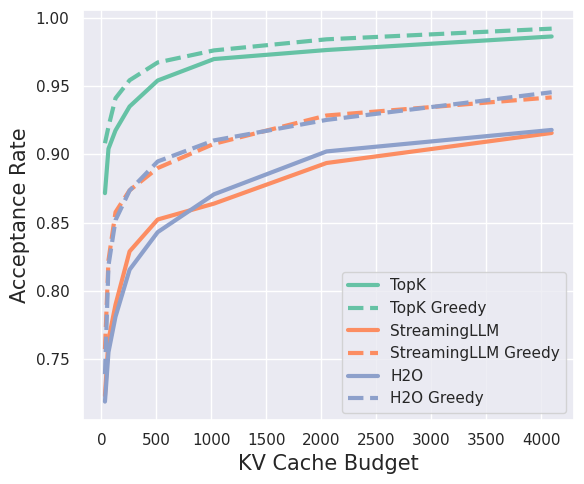

In [4]:
# ssl 2

budget = [32,64,128,256,512,1024,2048,4096]

# topk = [0.8513254551126973, 0.8890685210514462, 0.9059390823982534, 0.9241308998495313, 0.945546378063764, 0.9620035890872025, 0.9735389235019287, 0.9863215834481347]
# topk_greedy = [0.991824601761273]
# streamllm = [0.7209580661077193, 0.7558508395135772, 0.7924985527116097, 0.821395009769523, 0.8485980227501903, 0.8705645838275267, 0.8965677874887594, 0.91]
# h2o = [0.6894145184697548, 0.7405699126660549, 0.7727291984073, 0.800339151537593, 0.823248749178784, 0.8502516704914231, 0.8890675466583368, 0.9073338220468752]

topk = [0.8715662481614567, 0.9041054491326197, 0.9175314044888662, 0.9350267204906595, 0.9540918332283062, 0.9697996027728227, 0.9764057261245072, 0.9863215834481347]
topk_greedy =  [0.9081289923002818, 0.9201947852440386, 0.941093001477158, 0.9542628564690118, 0.9673225108073363, 0.9761301150519166, 0.984246527043834, 0.9920583636836696]
streamllm = [0.7233287923374752,0.764188003063453, 0.789870808341835, 0.8288902649699308, 0.8522712770198592,0.8638983815057629,0.8936457621514479,0.9156478633609554]
streamllm_greedy = [0.7573409520738212, 0.8223861998463301, 0.8576440488216768, 0.8736078247621512, 0.8899570718073336, 0.9077081559642489, 0.9284376411724862, 0.9417333194749585]
h2o = [0.7138743502532257, 0.7500735195967001, 0.7760754755038344, 0.8104934714770856, 0.8380275903925386, 0.8657072012504481, 0.8971291862758495, 0.9128685571720253]
h2o_greedy = [0.7339922908079762, 0.8136301370303344, 0.8467974573647802, 0.8684746180197715, 0.8897951250252422, 0.9052044076026817, 0.9202110931274585, 0.940474523976641]
h2o = [x+0.005 for x in h2o]
h2o_greedy = [x+0.005 for x in h2o_greedy]



import figures
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

plt.rcParams["font.family"] = "Times New Roman"
sns.set_theme()
# color1='#8da0cb'
# color2='#fc8d62'
# color3='#66c2a5'
# color4='brown'

color1 = '#66c2a5'
color2 = '#fc8d62'
color3 = '#8da0cb'
color4 = '#e78ac3'
color5 = '#a6d854'

# budget = [str(x) for x in budget]
plt.figure(figsize=(6,5))
plt.grid(True)
plt.plot(budget, topk, label='TopK', linewidth=3, color=color1)
plt.plot(budget, topk_greedy, label='TopK Greedy', linewidth=3, linestyle='--', color=color1)
plt.plot(budget, streamllm, label='StreamingLLM', linewidth=3, color=color2)
plt.plot(budget, streamllm_greedy, label='StreamingLLM Greedy', linewidth=3, linestyle='--', color=color2)
plt.plot(budget, h2o, label='H2O', linewidth=3, color=color3)
plt.plot(budget, h2o_greedy, label='H2O Greedy', linewidth=3, linestyle='--', color=color3)
plt.xlabel('KV Cache Budget', fontsize=15)
plt.ylabel('Acceptance Rate', fontsize=15)
plt.tight_layout()
plt.legend()
plt.savefig('Observation_Acceptance_Rate.png', dpi=300, bbox_inches='tight')

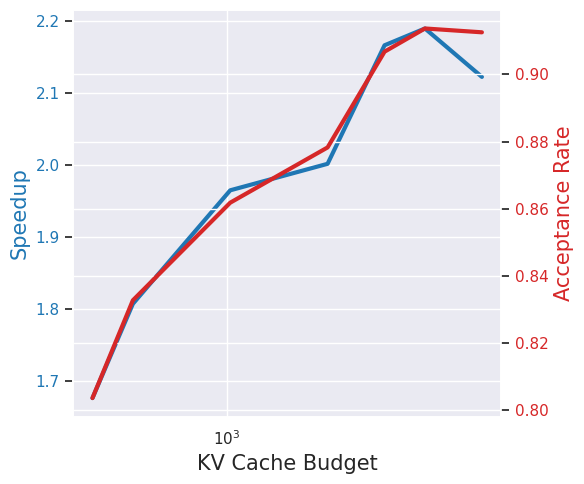

In [15]:
budget = [384, 512, 1024, 2048, 3072, 4096, 6144]
speedup = [1.67621987, 1.80707791, 1.96468919, 2.00149382, 2.16604938, 2.18939503, 2.12216916]
avg_tokens = [3.9892850, 4.3178513, 4.6808956, 4.9032048, 5.3195215, 5.4267500, 5.4088837]
acceptance_rate = [0.803555645198592,
 0.832688326670733,
 0.861776431710068,
 0.878241519073039,
 0.906767478847968,
 0.913683737316852,
 0.912542665927877]
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(6,5))

# Plot speedup on y-axis (left)
ax1.set_xlabel('KV Cache Budget', fontsize=15)
ax1.set_ylabel('Speedup', color='tab:blue', fontsize=15)
ax1.plot(budget, speedup, label='Speedup', linewidth=3, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)
# set xticks
ax1.set_xticks(budget)

# Create a second y-axis for avg_tokens
ax2 = ax1.twinx()
ax2.set_ylabel('Acceptance Rate', color='tab:red', fontsize=15)
ax2.plot(budget, acceptance_rate, label='Average Tokens', linewidth=3, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# x axis log scale
ax1.set_xscale('log')

fig.tight_layout()
fig.savefig('KV_budget.png', dpi=300, bbox_inches='tight')

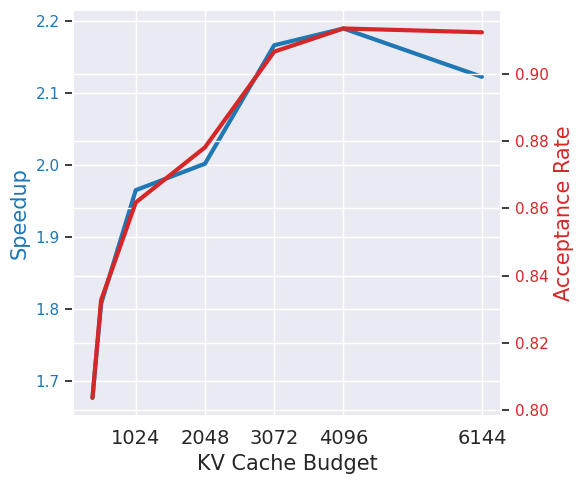

In [23]:
import matplotlib.pyplot as plt

budget = [384, 512, 1024, 2048, 3072, 4096, 6144]
speedup = [1.67621987, 1.80707791, 1.96468919, 2.00149382, 2.16604938, 2.18939503, 2.12216916]
avg_tokens = [3.9892850, 4.3178513, 4.6808956, 4.9032048, 5.3195215, 5.4267500, 5.4088837]
acceptance_rate = [0.803555645198592, 0.832688326670733, 0.861776431710068, 0.878241519073039, 0.906767478847968, 0.913683737316852, 0.912542665927877]

# Instead of using subplot, create a single figure and axis object.
fig, ax1 = plt.subplots(figsize=(6,5))

# Plot speedup with KV Cache Budget on the x-axis and Speedup on the y-axis (primary)
ax1.set_xlabel('KV Cache Budget', fontsize=15)
ax1.set_ylabel('Speedup', color='tab:blue', fontsize=15)
ax1.plot(budget, speedup, label='Speedup', linewidth=3, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)
# Set xticks
ax1.set_xticks(budget)

# Plot acceptance rate on the secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Acceptance Rate', color='tab:red', fontsize=15)
ax2.plot(budget, acceptance_rate, label='Acceptance Rate', linewidth=3, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# set xticks font size
ax1.tick_params(axis='x', labelsize=14)
# only display 512, 2048, 4096
ax1.set_xticks([1024, 2048, 3072, 4096, 6144])

# Adjust layout for tight fit and save the figure
fig.tight_layout()
plt.savefig('KV_budget.png', dpi=300, bbox_inches='tight')

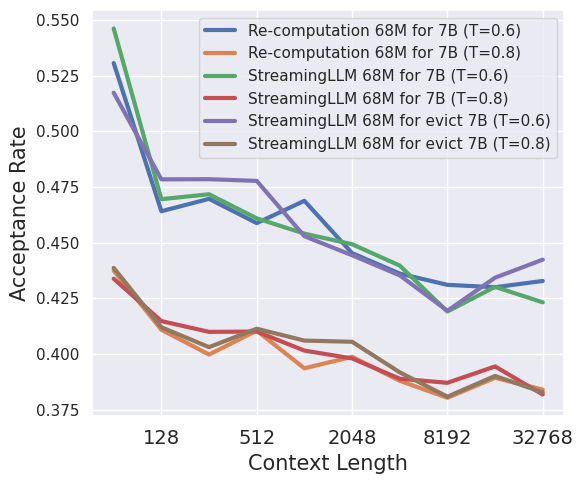

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.grid()
prefill_list = [1,128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 49152]


prefill = [1,128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 49152]
file_path = '../test/report/L40_recomp.csv'
df = pd.read_csv(file_path)
y_list = []
for p in prefill:
    table = df[df['prefill'] == p]
    table = table[table['temperature'] == 0.6]
    y_list.append(table['acceptance_rate'].mean())
plt.plot([str(x) for x in prefill_list], y_list, label='Re-computation 68M for 7B (T=0.6)',linewidth=3)

y_list = []
for p in prefill:
    table = df[df['prefill'] == p]
    table = table[table['temperature'] == 0.8]
    y_list.append(table['acceptance_rate'].mean())
plt.plot([str(x) for x in prefill_list], y_list, label='Re-computation 68M for 7B (T=0.8)',linewidth=3)

prefill = [1,128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 49152]
file_path = '../test/report/L40_evict_streamllm.csv'
df = pd.read_csv(file_path)
df = df[df['draft'] == 'JackFram/llama-68m']
y_list = []
for p in prefill:
    table = df[df['prefill'] == p]
    table = table[table['temperature'] == 0.6]
    y_list.append(table['acceptance_rate'].mean())
plt.plot([str(x) for x in prefill_list], y_list, label='StreamingLLM 68M for 7B (T=0.6)',linewidth=3)

y_list = []
for p in prefill:
    table = df[df['prefill'] == p]
    table = table[table['temperature'] == 0.8]
    y_list.append(table['acceptance_rate'].mean())
plt.plot([str(x) for x in prefill_list], y_list, linewidth=3, label='StreamingLLM 68M for 7B (T=0.8)')

prefill = [1,128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 49152]
file_path = '../test/report/L40_evict4evict.csv'
df = pd.read_csv(file_path)
y_list = []
for p in prefill:
    table = df[df['prefill'] == p]
    table = table[table['temperature'] == 0.6]
    y_list.append(table['acceptance_rate'].mean())
plt.plot([str(x) for x in prefill_list], y_list, linewidth=3, label='StreamingLLM 68M for evict 7B (T=0.6)')

y_list = []
for p in prefill:
    table = df[df['prefill'] == p]
    table = table[table['temperature'] == 0.8]
    y_list.append(table['acceptance_rate'].mean())
plt.plot([str(x) for x in prefill_list], y_list, linewidth=3, label='StreamingLLM 68M for evict 7B (T=0.8)')

plt.xlabel('Context Length', fontsize=15)
plt.ylabel('Acceptance Rate', fontsize=15)
plt.grid()
plt.legend()
plt.xticks(fontsize=14)
plt.xticks(['128','512', '2048', '8192', '32768'])
plt.tight_layout()
plt.savefig('acceptance_rate.png', dpi=300, bbox_inches='tight')

In [1]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("JackFram/llama-68m")

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [9]:
prompt = "The new algorithm for long context speculative decoding significantly enhances the quality inference speed of large language models, enabling more efficient natural language understanding tasks"
a = tokenizer.encode(prompt, return_tensors='pt')